In [28]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

### Cel
Celem klasyfikacji obrazów ze zbioru KAUHC jest wsparcie i usprawnienie diagnostyki chorób jelita cienkiego poprzez automatyczne wykrywanie nieprawidłowości na obrazach z endoskopii.

### Przetwarzanie zdjęć 
~ docelowy folder output
~ pozbycie się adnotacji widocznych na zdjęciach oraz elips zaznaczających miejsce występowania zmiany

In [2]:
# Ścieżka do folderu z oryginalnymi obrazami
input_root = "archive"
output_root = "output"

# Wymiary obrazków i granica (wyznaczona metodą prób i błędów)
h, w = (512, 512)
margin_x = int(w * 0.064)
margin_y = int(h * 0.064)

def fix_photos():
    # Przechodzimy rekurencyjnie przez wszystkie pliki w folderze archive
    for root, _, files in os.walk(input_root):
        for file in files:
            if file.endswith(".bmp"):  # Obsługujemy tylko pliki BMP
                input_path = os.path.join(root, file)

                # Odtworzenie struktury katalogów w output
                relative_path = os.path.relpath(root, input_root)
                output_dir = os.path.join(output_root, relative_path)
                os.makedirs(output_dir, exist_ok=True)

                base, ext = os.path.splitext(file)
                new_filename = f"{base}{ext}"
                output_path = os.path.join(output_dir, new_filename)

                image = cv2.imread(input_path)
            
                ### Usuwanie adnotacji znajdujących się na ramce ###
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                mask = np.where(gray > 10, 255, 0).astype(np.uint8) 
                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
                largest_contour = max(contours, key=cv2.contourArea)  
                (x, y), radius = cv2.minEnclosingCircle(largest_contour)
                center = (int(x), int(y))
                radius = int(radius * 1.05)
                circle_mask = np.zeros_like(gray)
                cv2.circle(circle_mask, center, radius, 255, thickness=-1)
                result = cv2.bitwise_and(image, image, mask=circle_mask) 

                ### Detekcja i usuwanie elips ###
                gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
                _, mask = cv2.threshold(gray_result, 10, 255, cv2.THRESH_BINARY_INV) 
                tmp_output = cv2.inpaint(result, mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA) 
                
                ### Przywracanie czarnego obramowania bez adnotacji ###
                gray = cv2.cvtColor(tmp_output, cv2.COLOR_BGR2GRAY)
                mask = np.where(gray > 10, 255, 0).astype(np.uint8)

                mask[:margin_y, :] = 0
                mask[-margin_y:, :] = 0
                mask[:, :margin_x] = 0
                mask[:, -margin_x:] = 0

                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                largest_contour = max(contours, key=cv2.contourArea)
                (x, y), radius = cv2.minEnclosingCircle(largest_contour)
                center = (int(x), int(y))
                radius = int(radius * 0.85)

                circle_mask = np.zeros_like(gray)
                cv2.circle(circle_mask, center, radius, 255, thickness=-1)

                output = cv2.bitwise_and(tmp_output, tmp_output, mask=circle_mask)

                ### Zapisanie wyniku ###
                cv2.imwrite(output_path, output)

# fix_photos()

### Usunięcie wadliwych zdjęć 
- widoczna etykieta lub źle dopasowane obramowanie, które może skutkować klasyfikowaniem zdjęć na podstawie tych cech
- jakość zdjęć nie zmieniła się od zdjęć orginalnych

In [7]:
folder_path = "output"
with open("delete_path.txt", "r") as file:
    files_to_delete = [line.strip() for line in file]
    
for file_name in files_to_delete:
    file_path = os.path.join(folder_path, file_name)
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Usunięto: {file_name}")
    else:
        print(f"Nie znaleziono: {file_name}")

Usunięto: Normal\Normal_2024-08-07-07-48-57_37769.bmp
Usunięto: Normal\Normal_2024-08-07-07-48-57_55534.bmp
Usunięto: Ulcer\Ulcer_2024-08-07-08-25-26_23438.bmp
Usunięto: Ulcer\Ulcer_2024-08-07-08-25-26_31440.bmp
Usunięto: Ulcer\Ulcer_2024-08-07-08-25-26_55334.bmp
Usunięto: Ulcer\Ulcer_2024-08-07-08-25-26_55599.bmp
Usunięto: Ulcer\Ulcer_2024-08-07-08-25-26_73172.bmp


### Znalezienie y i przypisanie ścieżek do x

In [ ]:
# Ścieżka do folderu z oryginalnymi obrazami

def save_to_list():
    output_root = "output"
    X = []
    y = []
    # Przechodzimy rekurencyjnie przez wszystkie pliki w folderze archive
    for root, _, files in os.walk(output_root):
        for file in files:
            if file.endswith(".bmp"):  # Obsługujemy tylko pliki BMP
                input_path = os.path.join(root, file)

                # Nowa nazwa pliku (dodajemy "0" przed rozszerzeniem)
                base, ext = os.path.splitext(file)
                new_filename = f"{base}{ext}"
                image = cv2.imread(input_path)
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                # zapisanie obrazu w grayscale (3x mniej danych)
                # TODO przezkalowanie z [0,255] do [0,1]
                X.append(gray)
                y.append(new_filename.split("_")[0])
    return X, y

# data_all = save_to_list()
# print(np.shape(data_all))
X, y = save_to_list()
np.shape(X)

c:\Users\czare\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [24]:
print(X[0])
print(X[0][0][270]) # mimo że wyświetlają się same zera na podglądzie to obrazek nie jest czarnym prostokątem

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
58


### Liczba zdjęć w orginale

In [8]:
parent_folder = "archive"
archive_data = []  

for folder in os.listdir(parent_folder):
    folder_path = os.path.join(parent_folder, folder)
    if os.path.isdir(folder_path):
        count = sum(1 for f in os.listdir(folder_path) if f.endswith(".bmp"))
        archive_data.append([folder, count])  

df_archive = pd.DataFrame(archive_data, columns=["Nazwa klasy", "Liczba zdjęć"])
df_archive

,Nazwa klasy,Liczba zdjęć
0,AVM,673
1,Normal,2156
2,Ulcer,472


### Liczba zdjęć po usunięciu

In [9]:
parent_folder = "output"
output_data = []  

for folder in os.listdir(parent_folder):
    folder_path = os.path.join(parent_folder, folder)
    if os.path.isdir(folder_path):
        count = sum(1 for f in os.listdir(folder_path) if f.endswith(".bmp"))
        output_data.append([folder, count])  
df_output = pd.DataFrame(output_data, columns=["Nazwa klasy", "Liczba zdjęć"])
df_output

,Nazwa klasy,Liczba zdjęć
0,AVM,673
1,Normal,2154
2,Ulcer,467


### Procent pozostawionych zdjęć

In [10]:
perc_left_photos = []
for i in range(len(archive_data)):
    perc_left_photos.append([archive_data[i][0], output_data[i][1] / archive_data[i][1] * 100])
    
perc_left_all = sum(output_data[i][1] for i in range(len(output_data)))/sum(archive_data[i][1] for i in range(len(archive_data))) * 100
df_perc_left_photos = pd.DataFrame(perc_left_photos, columns=["Nazwa klasy", "Procent zachowanych zdjęć"])
print(df_perc_left_photos)
print(f"Procent zachowanych zdjęć: {perc_left_all:.2f}%")

  Nazwa klasy  Procent zachowanych zdjęć
0         AVM                 100.000000
1      Normal                  99.907236
2       Ulcer                  98.940678
Procent zachowanych zdjęć: 99.79%


### Rozkład klas

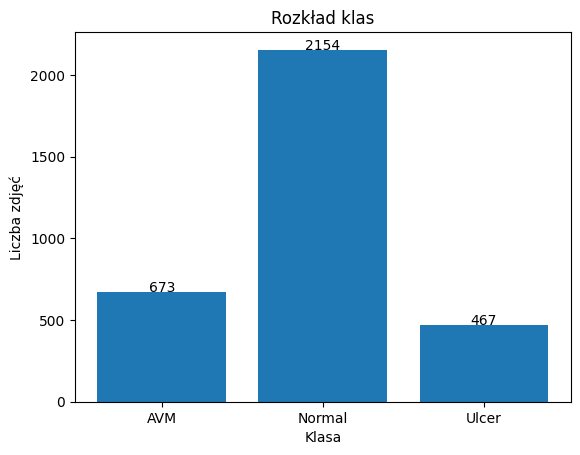

In [11]:
labels, values = zip(*output_data)  

bars = plt.bar(labels, values)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, 
            str(bar.get_height()), ha='center')
plt.xlabel("Klasa")
plt.ylabel("Liczba zdjęć")
plt.title("Rozkład klas")
plt.style.use('fivethirtyeight') 
plt.show()

## Podzielenie datasetu

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=123)

print(np.shape(X_train),np.shape(X_test),np.shape(X_val))
print(np.shape(y_train),np.shape(y_test),np.shape(y_val))

(2305,) (494,) (495,)
(2305,) (494,) (495,)


c:\Users\czare\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
